# Lane Switch Agents

## Rule-Based Agent

In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np

from environment_gym import TrafficEnvironment

### Agent Implementation

In [2]:
class RuleBasedAgent:
    def choose_action(self, state_history):
        """
        Chooses an action based on the most recent state in the history (clearance rates and current lane).
        - state_history: A list of the last three state records (each state is a tuple).
        """
        # Use the most recent state (the last element in the state history)
        current_state = state_history[-7:]

        # Extract the current lane and clearance rates from the most recent state
        current_distance, current_lane, *clearance_rates = current_state
        current_lane = int(current_lane)
        current_clearance_rate = clearance_rates[current_lane - 1]
        
        print(f'current_state: {current_state}')
        print(f'clearance_rates: {clearance_rates}')

        # Check neighboring lanes
        left_lane = current_lane - 1 if current_lane > 1 else None
        right_lane = current_lane + 1 if current_lane < len(clearance_rates) else None

        # Compare clearance rates
        if left_lane is not None and clearance_rates[left_lane - 1] > current_clearance_rate:
            # Move left if the left lane has a higher clearance rate
            return -1  # Move left
        elif right_lane is not None and clearance_rates[right_lane - 1] > current_clearance_rate:
            # Move right if the right lane has a higher clearance rate
            return 1  # Move right
        else:
            # Stay in the current lane if it has the best or comparable clearance rate
            return 0  # Stay

### Testing

In [3]:
env = TrafficEnvironment()
state_history, _ = env.reset()
current_distance, current_lane, *clearance_rates = state_history[-7:]

In [4]:
env = TrafficEnvironment()
state_history, _ = env.reset()  # state_history contains the last 3 records
terminated = False
rewards = []  # To track rewards at each time step
time_steps = []  # To track the time step number

# Create an instance of the RuleBasedAgent
agent = RuleBasedAgent()

time_step_counter = 0

while not terminated:
    # Pass the current state history (last 3 records) to the agent and get the action
    action = agent.choose_action(state_history)

    # Take the step in the environment with the chosen action
    next_state, reward, terminated, truncated, info = env.step(action)

    # Append the reward for this time step
    rewards.append(reward)
    time_steps.append(time_step_counter)

    # Increment the time step counter
    time_step_counter += 1

    print(f"Action: {action}, Reward: {reward}, Terminated: {terminated}")
    print(f"Next State: {next_state}")

    # Update the state history (append the new state)
    state_history = env._get_obs()

# Sum up all rewards at the end of the simulation
total_reward = sum(rewards)
print(f"Total Reward: {total_reward}")

current_state: [4.00e+03 1.00e+00 1.97e+01 1.97e+01 1.65e+01 1.55e+01 1.60e+01]
clearance_rates: [np.float32(19.7), np.float32(19.7), np.float32(16.5), np.float32(15.5), np.float32(16.0)]
Action: 0, Reward: 4.7, Terminated: False
Next State: [4.0000e+03 1.0000e+00 1.9700e+01 1.9700e+01 1.6500e+01 1.5500e+01
 1.6000e+01 4.0000e+03 1.0000e+00 1.9700e+01 1.9700e+01 1.6500e+01
 1.5500e+01 1.6000e+01 3.9803e+03 1.0000e+00 1.9700e+01 1.9500e+01
 1.6500e+01 1.6000e+01 1.5800e+01]
current_state: [3.9803e+03 1.0000e+00 1.9700e+01 1.9500e+01 1.6500e+01 1.6000e+01
 1.5800e+01]
clearance_rates: [np.float32(19.7), np.float32(19.5), np.float32(16.5), np.float32(16.0), np.float32(15.8)]
Action: 0, Reward: 4.6, Terminated: False
Next State: [4.0000e+03 1.0000e+00 1.9700e+01 1.9700e+01 1.6500e+01 1.5500e+01
 1.6000e+01 3.9803e+03 1.0000e+00 1.9700e+01 1.9500e+01 1.6500e+01
 1.6000e+01 1.5800e+01 3.9607e+03 1.0000e+00 1.9600e+01 1.9500e+01
 1.6600e+01 1.5900e+01 1.2400e+01]
current_state: [3.9607e+03 1.

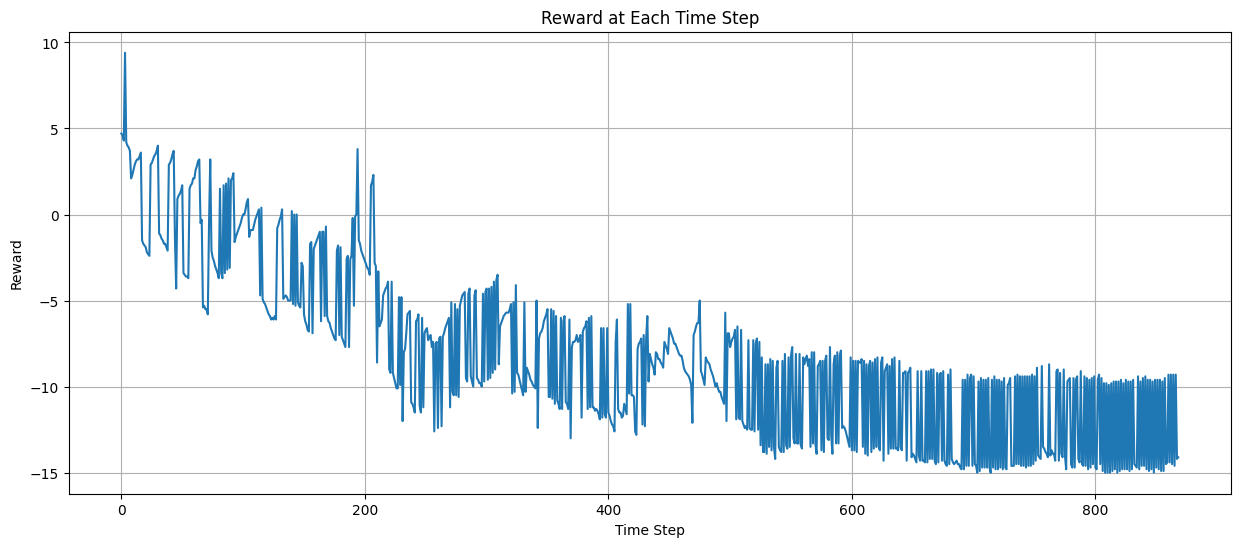

In [5]:
# Plot the rewards over time
plt.figure(figsize=(15, 6))
plt.plot(time_steps, rewards)
plt.title('Reward at Each Time Step')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

In [6]:
# Sum up all rewards at the end of the simulation
total_reward = sum(rewards)
print(f"Total Reward: {total_reward}")

Total Reward: -7059.600000000008


In [19]:
# Number of episodes
num_episodes = 1000

# Track results
total_rewards = []  # To store the total reward of each episode
episode_lengths = []  # To store how many time steps each episode took

# Initialize a new environment for each episode
env = TrafficEnvironment()
# Initialize agent
agent = RuleBasedAgent()

# Loop over 1000 episodes
for episode in range(num_episodes):
    
    # Reset environment to get the initial state
    state = env.reset()
    done = False
    total_reward = 0
    time_steps = 0

    # Run the simulation for the current episode
    while not done:
        # Agent chooses an action based on the current state
        action = agent.choose_action(state)

        # Environment executes the action and returns the new state, reward, and done flag
        state, reward, done = env.step(action)

        # Accumulate the total reward
        total_reward += reward

        # Increment the time step counter
        time_steps += 1

    # Store the results for this episode
    total_rewards.append(total_reward)
    episode_lengths.append(time_steps)

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

# After all episodes are done, print out the average reward and episode length
print(f"Average Total Reward over {num_episodes} episodes: {np.mean(total_rewards)}")
print(f"Average Episode Length over {num_episodes} episodes: {np.mean(episode_lengths)}")

Episode 100/1000 completed.
Episode 200/1000 completed.
Episode 300/1000 completed.
Episode 400/1000 completed.
Episode 500/1000 completed.
Episode 600/1000 completed.
Episode 700/1000 completed.
Episode 800/1000 completed.
Episode 900/1000 completed.
Episode 1000/1000 completed.
Average Total Reward over 1000 episodes: -4456.036900000002
Average Episode Length over 1000 episodes: 675.089
